## Model Selection with basic models

### By:
[Jose R. Zapata](https://joserzapata.github.io/)

### Date:
2024-11-02

### Description:

Select the best machine learning model for the Titanic dataset.

The models at least has to be better than the baseline model (heuristic approach). 

<https://github.com/JoseRZapata/demo-data-science-template/blob/main/notebooks/5-models/01-jrz-heuristic_model-2024_10_29.ipynb>

## 📚 Import  libraries

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

## 💾 Load data

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

titanic_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/titanic_type_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.1.4


## 👷 Data preparation

The columns that will be used are:

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


In [4]:
selected_features = [
    "pclass",
    "sex",
    "age",
    "sibsp",
    "parch",
    "fare",
    "embarked",
    "survived",
]

titanic_features = titanic_df[selected_features]

titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   int64   
 1   sex       1309 non-null   category
 2   age       1046 non-null   float64 
 3   sibsp     1309 non-null   int64   
 4   parch     1309 non-null   int64   
 5   fare      1308 non-null   float64 
 6   embarked  1307 non-null   category
 7   survived  1309 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(3)
memory usage: 55.3 KB


In [5]:
titanic_features.isna().sum()

pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
survived      0
dtype: int64

The target variable is `survived` and the values are True or False.
I'm going to transform the target variable to 1 or 0.

In [6]:
titanic_features.loc[:, "survived"] = titanic_features["survived"].astype(int)

drop duplicates if any exist in the dataset, is important to avoid any bias in the dataset or data leakage when a machine learning model is trained on the data.

Duplicated values creates bias in the dataset, and the model will be trained on the same data, which will lead to overfitting, and data leakage problems.

In [7]:
titanic_features = titanic_features.drop_duplicates()
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1114 non-null   int64   
 1   sex       1114 non-null   category
 2   age       974 non-null    float64 
 3   sibsp     1114 non-null   int64   
 4   parch     1114 non-null   int64   
 5   fare      1113 non-null   float64 
 6   embarked  1112 non-null   category
 7   survived  1114 non-null   int64   
dtypes: category(2), float64(2), int64(4)
memory usage: 63.3 KB


After select only 3 columns theres a lot of duplicates, then more columns are selected the probability of duplicates is lower.

I'm Not going to drop duplicates in this case. to keep the 1309 rows to compare with the machine learning models that uses more columns.

In [8]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1114 non-null   int64   
 1   sex       1114 non-null   category
 2   age       974 non-null    float64 
 3   sibsp     1114 non-null   int64   
 4   parch     1114 non-null   int64   
 5   fare      1113 non-null   float64 
 6   embarked  1112 non-null   category
 7   survived  1114 non-null   int64   
dtypes: category(2), float64(2), int64(4)
memory usage: 63.3 KB


In [9]:
titanic_features.isna().sum()

pclass        0
sex           0
age         140
sibsp         0
parch         0
fare          1
embarked      2
survived      0
dtype: int64

In [10]:
titanic_features.sample(10, random_state=42)

,pclass,sex,age,sibsp,parch,fare,embarked,survived
969,3,female,30.0,1,0,15.5500,S,0
101,1,male,39.0,0,0,29.7000,C,0
1306,3,male,26.5,0,0,7.2250,C,0
784,3,male,23.0,1,0,13.9000,S,0
299,1,male,40.0,0,0,27.7208,C,0
958,3,female,NaN,0,4,25.4667,S,0
1075,3,male,23.0,0,0,9.2250,S,0
267,1,male,56.0,0,0,30.6958,C,0
130,1,female,22.0,0,1,59.4000,C,1
1190,3,male,25.0,0,0,9.5000,S,1


## 👨‍🏭 Feature Engineering

In [11]:
cols_numeric = ["age", "fare", "sibsp", "parch"]
cols_categoric = ["sex", "embarked"]
cols_categoric_ord = ["pclass"]

`age` column needs imputation, for this model, we will use the median value. but categorical columns don't need nothing for this heuristic model.

In [12]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, cols_numeric),
        ("categoric", categorical_pipe, cols_categoric),
        ("categoric ordinal", categorical_ord_pipe, cols_categoric_ord),
    ]
)

In [13]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'fare', 'sibsp', 'parch']),
                                ('categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['sex', 'embarked']),
                                ('categoric ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['pclass'])])

## Train / Test split

In [14]:
X_features = titanic_features.drop("survived", axis="columns")
Y_target = titanic_features["survived"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [15]:
x_train.shape, y_train.shape

((891, 7), (891,))

In [16]:
x_test.shape, y_test.shape

((223, 7), (223,))

Example of the data preprocessing pipeline:



In [17]:
# train pipeline
preprocessor.fit(x_train)

# obtener el nombre de las columnas de salida del preprocesamiento
# usando .get_feature_names_out()
feature_names = preprocessor.get_feature_names_out()

# transform x_Test with preprocessor and pandas output set
x_test_transformed = preprocessor.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=feature_names)
x_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   numeric__age               223 non-null    float64
 1   numeric__fare              223 non-null    float64
 2   numeric__sibsp             223 non-null    float64
 3   numeric__parch             223 non-null    float64
 4   categoric__sex_female      223 non-null    float64
 5   categoric__sex_male        223 non-null    float64
 6   categoric__embarked_C      223 non-null    float64
 7   categoric__embarked_Q      223 non-null    float64
 8   categoric__embarked_S      223 non-null    float64
 9   categoric ordinal__pclass  223 non-null    float64
dtypes: float64(10)
memory usage: 17.6 KB


In [18]:
x_test_transformed.sample(5)

,numeric__age,numeric__fare,numeric__sibsp,numeric__parch,categoric__sex_female,categoric__sex_male,categoric__embarked_C,categoric__embarked_Q,categoric__embarked_S,categoric ordinal__pclass
32,36.0,0.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
17,30.0,8.6625,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
41,28.5,14.5000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0
103,21.0,61.3792,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
174,31.0,37.0042,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


## Models

Best Practices is to import the libraries at the beginning of the notebook, but for this notebook, the libraries are imported in the cell where they are used.

In this experiments Basic Machine Learning models are used, and the models are:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Basic Model Selection

The models are trained with the default hyperparameters, and the models with the best performance will be selected to be tuned in the next step

### Helping functions

In [20]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}

In [ ]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test

    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", classifier_fn)])

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    return {"train": train_summary, "test": test_summary}

## First Selection of Models

The idea is to do a simple train an evaluate the models to see which ones are the worts to discard them.

In [22]:
FEATURES = list(x_train.columns)
FEATURES

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

### Simple Train and Evaluate

In [23]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "sgd": SGDClassifier(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "radius_neighbors": RadiusNeighborsClassifier(radius=40.0),
    "naive_bayes": GaussianNB(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

data_params = {
    "name_of_y_col": "survived",
    "names_of_x_cols": FEATURES,
    "dataset": titanic_df,
}
for model_name, model in models.items():
    result_dict[model_name] = build_model(model, preprocessor, data_params)

### Model Comparison

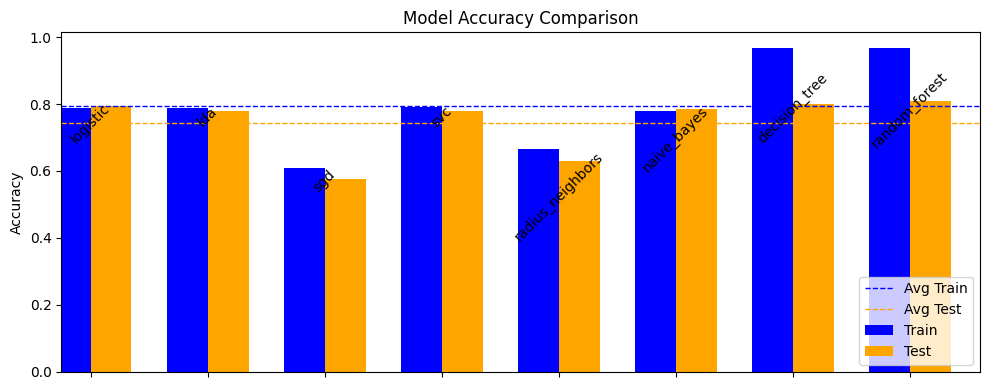

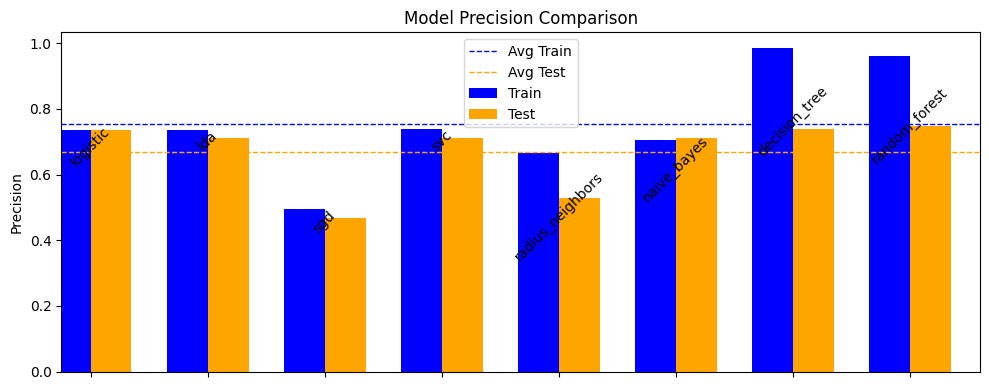

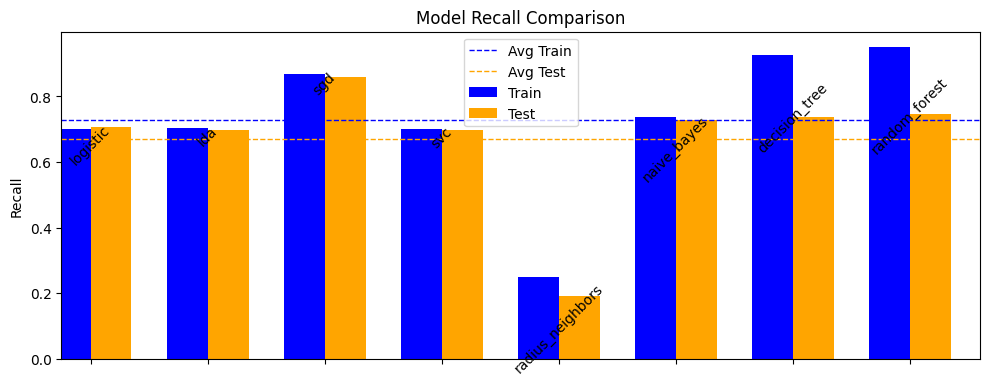

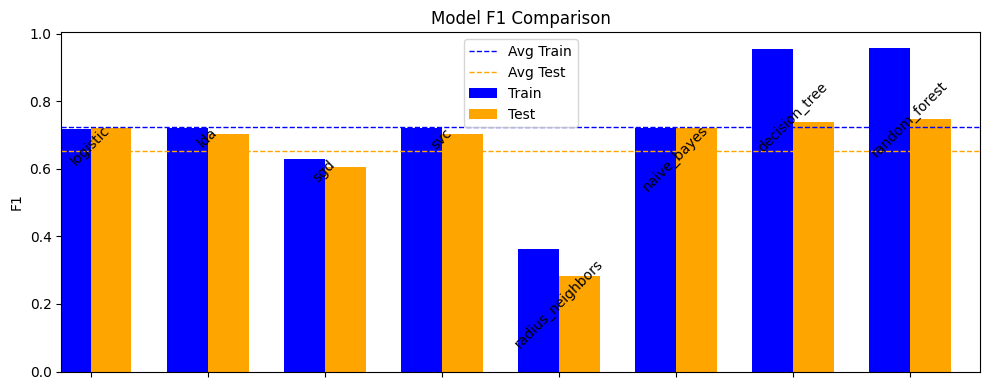

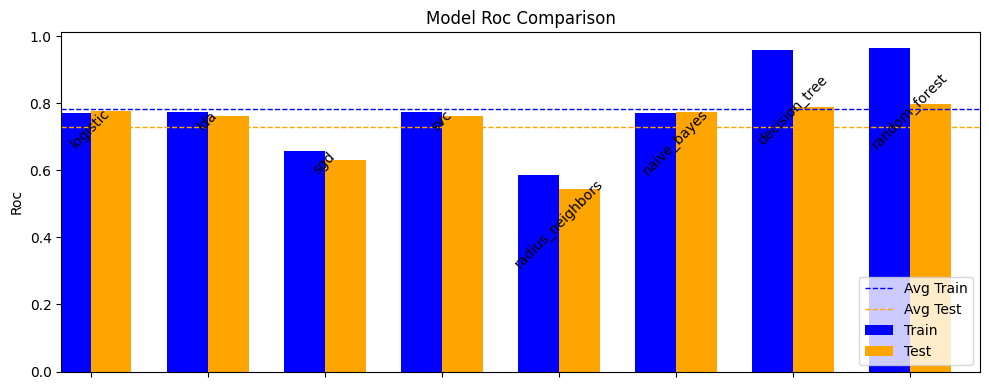

In [24]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models} for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models} for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(kind="bar", ax=ax, width=width, position=1, label="Train", color="blue")
    df_test[metric].plot(kind="bar", ax=ax, width=width, position=0, label="Test", color="orange")

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()

In [25]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat([df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = df_combined["accuracy_train"] - df_combined["accuracy_test"]
df_combined["precision_diff"] = df_combined["precision_train"] - df_combined["precision_test"]
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")

Models with overfitting: ['radius_neighbors', 'decision_tree', 'random_forest'] 
Models with low performance: ['radius_neighbors'] 


In [26]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    f"Models with similar performance in train and test: {list(similar_performance_models.index)}"
)

Models with similar performance in train and test: ['logistic', 'lda', 'sgd', 'svc', 'naive_bayes']


In [27]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
radius_neighbors,0.664756,0.666667,0.249377,0.362976,0.585989,0.629771,0.527778,0.191919,0.281481,0.543812,0.034985,0.138889,0.057457,0.081495,0.042176
decision_tree,0.966571,0.984127,0.927681,0.955071,0.959196,0.801527,0.737374,0.737374,0.737374,0.788932,0.165044,0.246753,0.190307,0.217697,0.170264
random_forest,0.966571,0.962121,0.950125,0.956085,0.963452,0.809160,0.747475,0.747475,0.747475,0.797050,0.157411,0.214646,0.202650,0.208611,0.166402


In [28]:
low_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
radius_neighbors,0.664756,0.666667,0.249377,0.362976,0.585989,0.629771,0.527778,0.191919,0.281481,0.543812,0.034985,0.138889,0.057457,0.081495,0.042176


In [29]:
similar_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
logistic,0.788921,0.735602,0.700748,0.717752,0.772201,0.793893,0.736842,0.707071,0.721649,0.776848,-0.004972,-0.001240,-0.006323,-0.003897,-0.004648
lda,0.789876,0.736292,0.703242,0.719388,0.773448,0.778626,0.711340,0.696970,0.704082,0.762595,0.011250,0.024952,0.006272,0.015306,0.010852
sgd,0.609360,0.494318,0.867830,0.629864,0.658373,0.576336,0.467033,0.858586,0.604982,0.631747,0.033024,0.027285,0.009245,0.024882,0.026626
svc,0.790831,0.739474,0.700748,0.719590,0.773749,0.778626,0.711340,0.696970,0.704082,0.762595,0.012205,0.028133,0.003778,0.015509,0.011153
naive_bayes,0.780325,0.704057,0.735661,0.719512,0.771855,0.786260,0.712871,0.727273,0.720000,0.774679,-0.005935,-0.008814,0.008388,-0.000488,-0.002824


Based on the results:

**Models to discard:**
- stochastic gradient descent (sgd)
- radius neighbors classifier

the models that will be selected to the next step for cross-validation are:
- logistic regression (simple, good performance and high interpretability)
- linear discriminant analysis (simple, good performance and high interpretability)
- Decision Tree (simple, good performance and high interpretability, but can be overfitting)
- Random Forest (simple, good performance and high interpretability, but can be overfitting)


svc and gaussian naive bayes are not selected because they have similar performance than the other models, and svc needs more time to train with more data, naive bayes is a simple model, but theres not range to improve the performance because of the hiperparameters options.



## Cross validation model Selection

In [30]:
# Define the models to evaluate
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Cross-validation evaluation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            model_pipe, x_train, y_train, cv=kfold, scoring=metric
        )

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}

In [31]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,logistic,accuracy,0.754232,0.050505
1,lda,accuracy,0.759838,0.045816
2,decision_tree,accuracy,0.704831,0.031282
3,random_forest,accuracy,0.747541,0.054167
4,logistic,f1,0.696035,0.063003
5,lda,f1,0.706033,0.055827
6,decision_tree,f1,0.638702,0.050070
7,random_forest,f1,0.680603,0.053718
8,logistic,precision,0.725963,0.086759
9,lda,precision,0.727254,0.077692


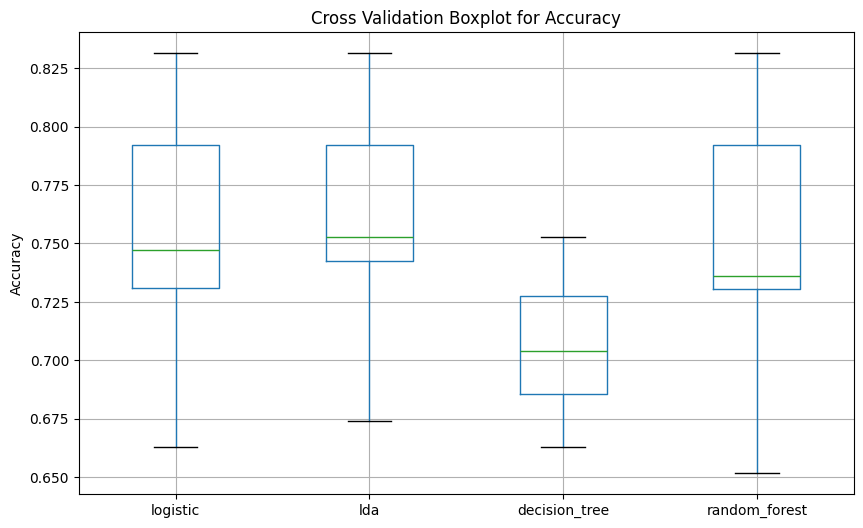

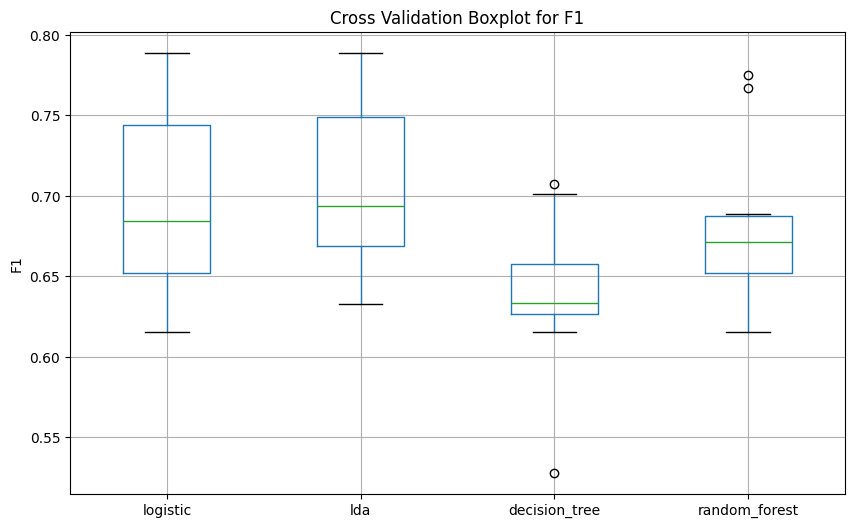

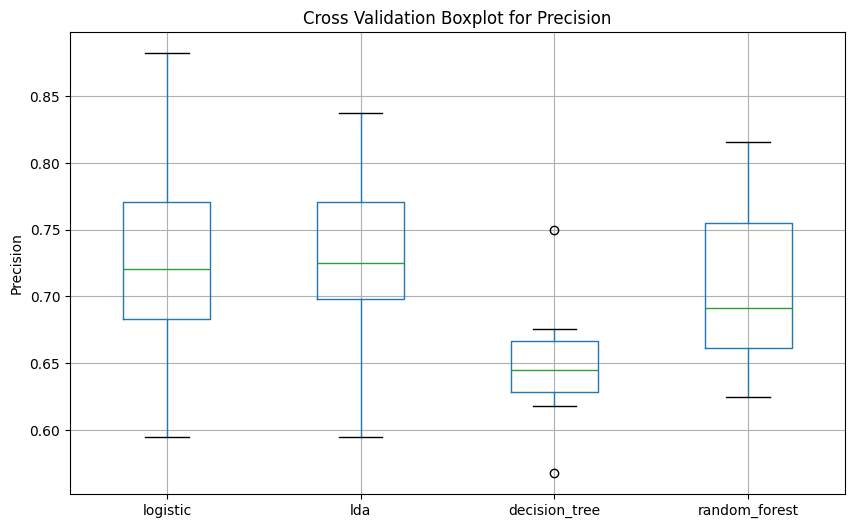

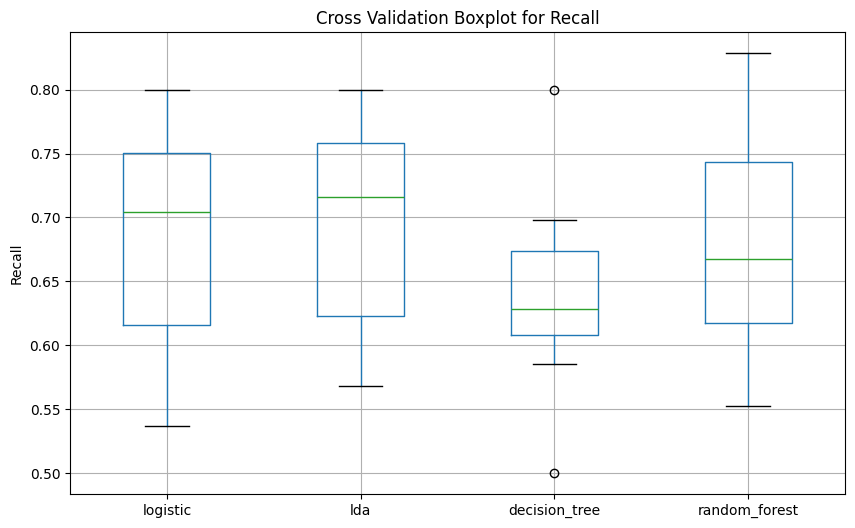

In [32]:
# Create a boxplot for the cross-validation results of each metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.capitalize()}")
    plt.ylabel(f"{metric_name.capitalize()}")
    plt.show()

### Only one Metric (Recall)

The  Recall (Sensitivity or True Positive Rate) metric is chosen for this model because it is more important to identify all positive cases (survivors) in order to take appropriate actions.

The objetive of this model is to identify all the survivors with out missing any of them, hypothetically the model is going to be used to take actions to save the passengers, so the recall metric is the most important metric for this model.

Recall is important because it Measures the model's ability to correctly identify passengers who survived. It is crucial in situations where it is more important to identify all positive cases (survivors) in order to take appropriate actions, and it is not as important to identify negative cases (non-survivors). The False Negative (FN) is the most important error in this case.

### Statistical Model Comparison

In [33]:
result_df = cv_results_df["recall"]
result_df

,logistic,lda,decision_tree,random_forest
0,0.710526,0.710526,0.605263,0.657895
1,0.545455,0.568182,0.636364,0.590909
2,0.758621,0.758621,0.620690,0.758621
3,0.727273,0.757576,0.666667,0.696970
4,0.789474,0.789474,0.500000,0.552632
5,0.617647,0.647059,0.676471,0.676471
6,0.697674,0.720930,0.697674,0.767442
7,0.800000,0.800000,0.800000,0.828571
8,0.615385,0.615385,0.615385,0.641026
9,0.536585,0.585366,0.585366,0.609756


In [34]:
from scipy.stats import f_oneway

model1 = result_df["logistic"]
model2 = result_df["lda"]
model3 = result_df["decision_tree"]
model4 = result_df["random_forest"]

statistic, p_value = f_oneway(model1, model2, model3, model4)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05  # significance level

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation results of the models."
    )

Statistic: 0.7222098102210205
p_value: 0.5453297538007467
There is no statistically significant difference in the cross-validation results of the models.


statistically all the models are similar, so two models are selected to be tuned in the next step:

- logistic regression (because is simple and has a good performance)
- Random Forest (because its implementation are different than logistic regression, and can be tuned with multiple hyperparameters)

## Hyperparameter tunning

Select the best hyperparameters for the models selected in the previous step.

### Logistic Regression

In [35]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = {"model__penalty": ["l1", "l2"], "model__C": [0.1, 0.4, 0.8, 1, 2, 5]}

modelo = LogisticRegression(solver="liblinear")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])

grid_search = GridSearchCV(logistic_pipe, parameters, cv=5, scoring=score, return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'fare',
                                                                          'sibsp',
                                                                          'parch']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'embarked']),
                                                                        ('categoric '
                                                                         'ordinal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OrdinalEncoder())]),
                                                                         ['pclass'])])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'model__C': [0.1, 0.4, 0.8, 1, 2, 5],
                         'model__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='recall')

In [36]:
grid_search.best_params_

{'model__C': 0.8, 'model__penalty': 'l1'}

#### Evaluation Logistic Regression

In [37]:
model = LogisticRegression(solver="liblinear", C=0.8, penalty="l1")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

logistic_model = logistic_pipe.fit(x_train, y_train)

In [38]:
y_pred = logistic_model.predict(x_test)

summarize_classification(y_test, y_pred)

{'accuracy': 0.8026905829596412,
 'precision': 0.7692307692307693,
 'recall': 0.7526881720430108,
 'f1': 0.7608695652173912,
 'roc': 0.7955748552522746}

### Random Forest

In [39]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = {
    "model__max_depth": [4, 5, 7, 9, 10],
    "model__max_features": [2, 3, 4, 5, 6, 7, 8, 9],
    "model__criterion": ["gini", "entropy"],
}

randomforest_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier())]
)

grid_search = GridSearchCV(
    randomforest_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'fare',
                                                                          'sibsp',
                                                                          'parch']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'embarked']),
                                                                        ('categoric '
                                                                         'ordinal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OrdinalEncoder())]),
                                                                         ['pclass'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 5, 7, 9, 10],
                         'model__max_features': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='recall')

In [40]:
grid_search.best_params_

{'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 2}

#### Evaluation Random Forest

In [41]:
modelo = RandomForestClassifier(criterion="entropy", max_depth=4, max_features=4)

Tree_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])

In [42]:
tree_model = Tree_pipe.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
summarize_classification(y_test, y_pred)

{'accuracy': 0.8251121076233184,
 'precision': 0.8214285714285714,
 'recall': 0.7419354838709677,
 'f1': 0.7796610169491526,
 'roc': 0.8132754342431762}

### Final Evaluation Test

In [43]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)

#### Logistic Regression

In [44]:
y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       130
           1       0.77      0.75      0.76        93

    accuracy                           0.80       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.80      0.80      0.80       223



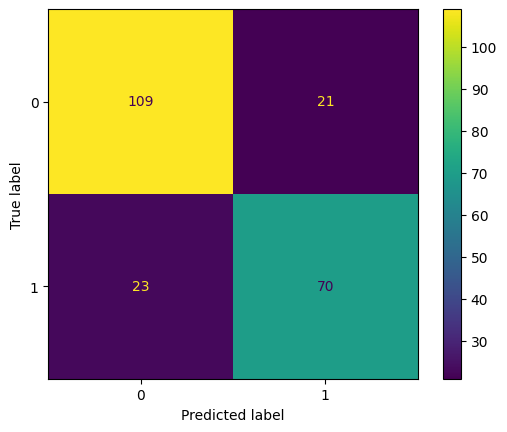

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

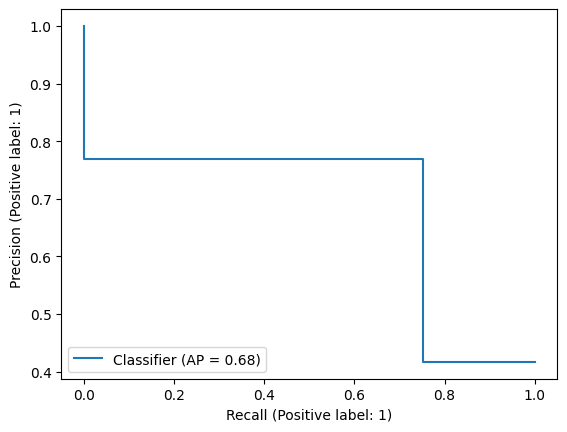

In [46]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

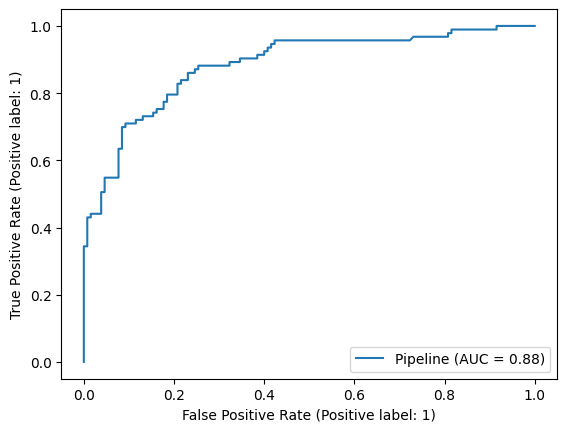

In [47]:
log_plot = RocCurveDisplay.from_estimator(logistic_model, x_test, y_test)
plt.show()

#### Random Forest

In [48]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       130
           1       0.82      0.74      0.78        93

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.82      0.83      0.82       223



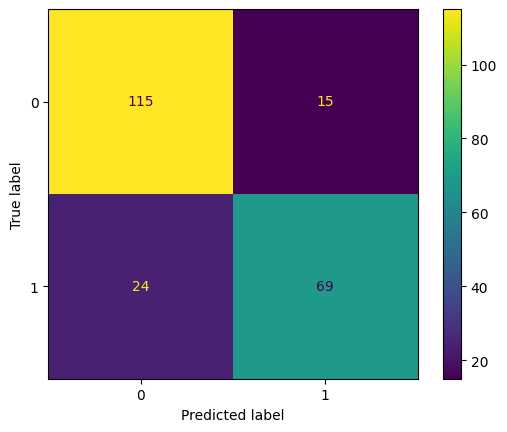

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

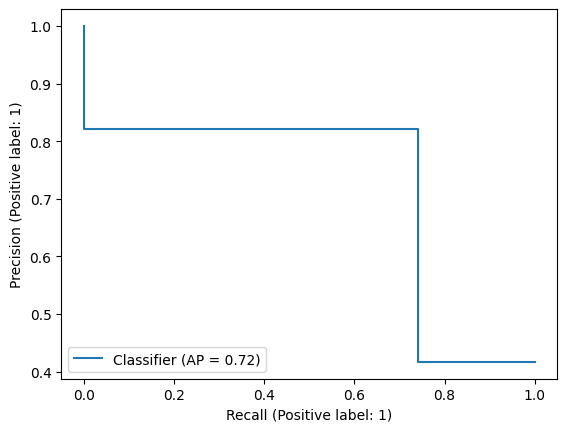

In [50]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

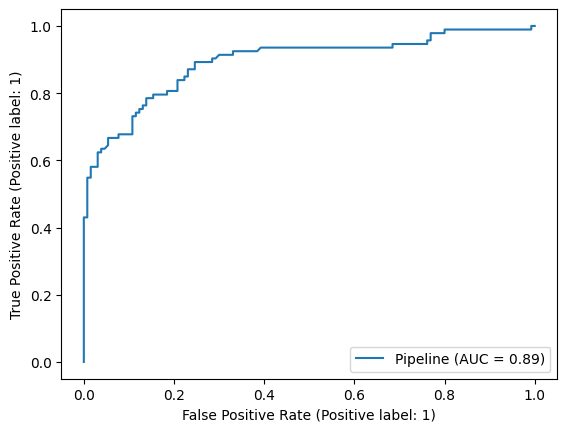

In [51]:
dt_plot = RocCurveDisplay.from_estimator(tree_model, x_test, y_test)
plt.show()

## Model comparison

Recall values are similar, but Random Forest has a little better performance than Logistic Regression, so Random Forest is selected as the best model for this dataset.

ROC curve is used to compare the models.


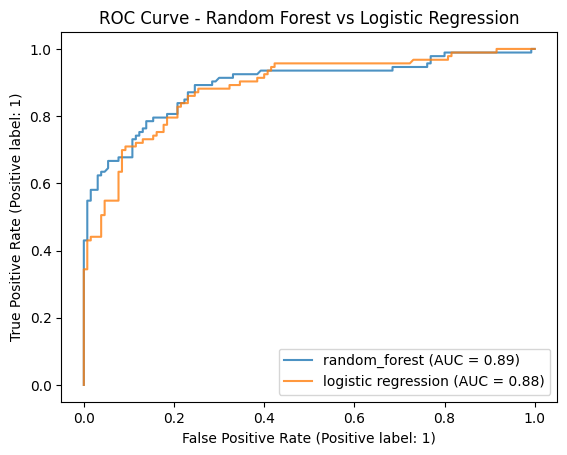

In [52]:
ax = plt.gca()
dt_plot.plot(ax=ax, alpha=0.8, name="random_forest")
log_plot.plot(ax=ax, alpha=0.8, name="logistic regression")
plt.title("ROC Curve - Random Forest vs Logistic Regression")
plt.show()

## Random Forest Learning Curve

This curve is used to see if the model is overfitting or underfitting.

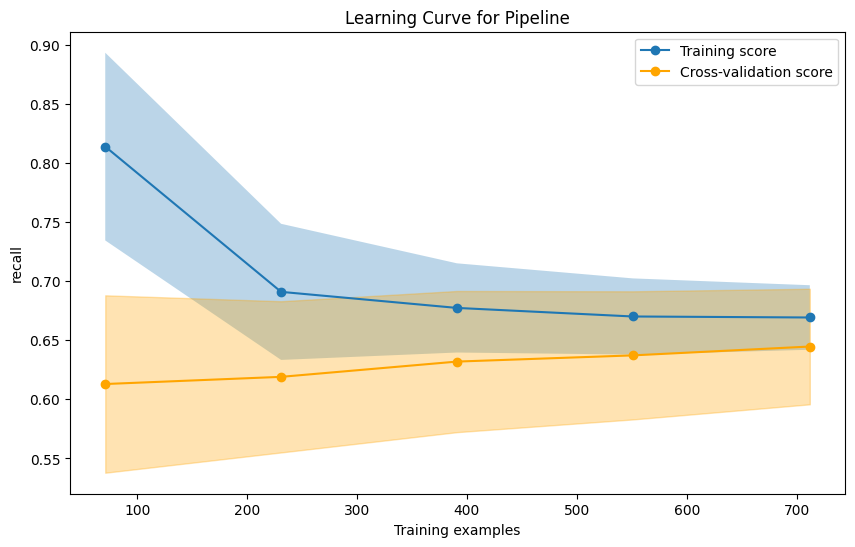

Training Sizes: [ 71 231 391 551 712]
Training Scores Mean: [0.81382816 0.6909304  0.6773471  0.67010412 0.66925488]
Training Scores Std: [0.07939262 0.05756737 0.03772593 0.03222352 0.02729735]
Test Scores Mean: [0.61297436 0.61904138 0.63195306 0.63720044 0.64468211]
Test Scores Std: [0.07503364 0.06395101 0.05970187 0.05418839 0.04888169]


In [53]:
model = tree_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange")

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

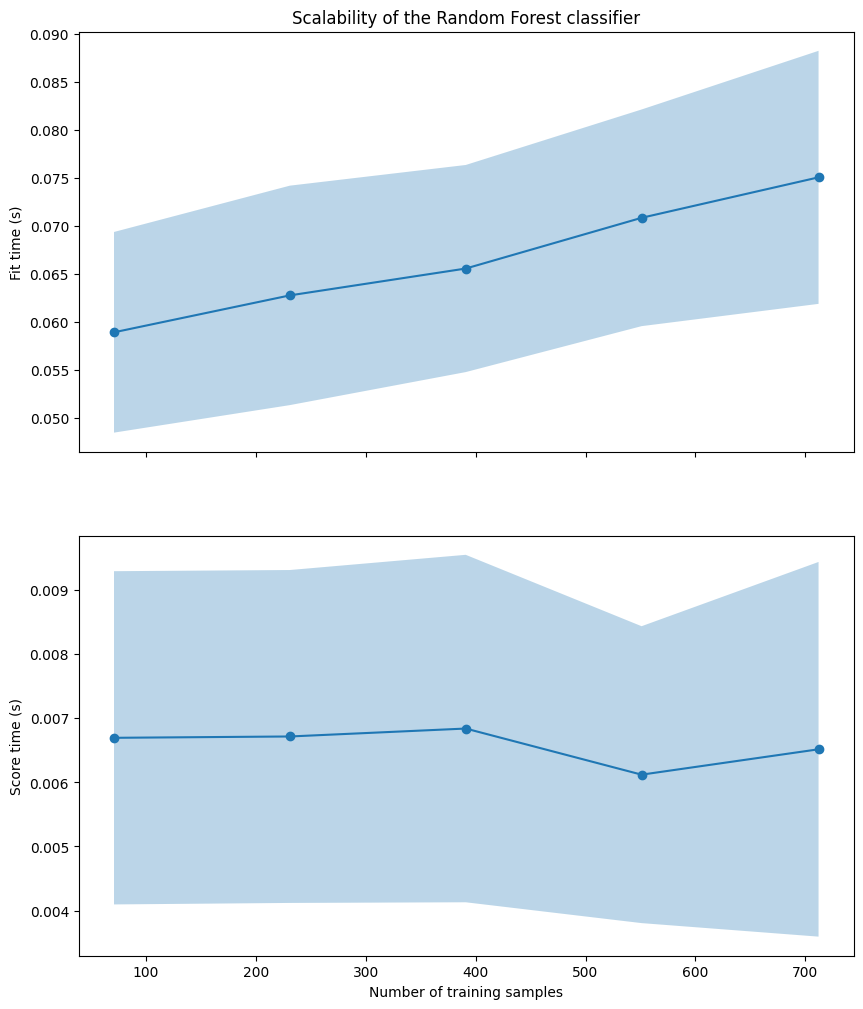

Fit Times Mean: [0.05894506 0.06279021 0.06558596 0.07086827 0.07508377]
Fit Times Std: [0.01044859 0.01142745 0.01078453 0.01128258 0.01317722]
Score Times Mean: [0.00669562 0.00671644 0.00684018 0.00612065 0.00651652]
Score Times Std: [0.00259971 0.00259719 0.00271066 0.00231618 0.002923  ]


In [54]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the Random Forest classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

## Model Interpretation

In [55]:
dfFeatures = pd.DataFrame(
    {
        "Features": tree_model["preprocessor"].get_feature_names_out(),
        "Importances": tree_model["model"].feature_importances_,
    }
)
dfFeatures.sort_values(by="Importances", ascending=False)

,Features,Importances
4,categoric__sex_female,0.274651
5,categoric__sex_male,0.263831
9,categoric ordinal__pclass,0.146375
1,numeric__fare,0.133972
0,numeric__age,0.086363
2,numeric__sibsp,0.034428
6,categoric__embarked_C,0.022848
3,numeric__parch,0.022657
8,categoric__embarked_S,0.012933
7,categoric__embarked_Q,0.001942


## Save the model

In [56]:
from joblib import dump

# grabar el modelo en un archivo
dump(Tree_pipe, "Tree_pipe-titanic.joblib")

['Tree_pipe-titanic.joblib']

#### Test the saved model

In [57]:
from joblib import load

my_model = load("Tree_pipe-titanic.joblib")

In [58]:
# test data

x_test.head()

,pclass,sex,age,sibsp,parch,fare,embarked
1237,3,male,24.0,0,0,7.7958,S
509,2,male,39.0,0,0,26.0000,S
739,3,male,44.0,0,1,16.1000,S
195,1,female,16.0,0,0,86.5000,S
839,3,male,19.0,0,0,7.7750,S


In [59]:
# check predictions
my_model.predict(x_test.head())

array([0, 0, 0, 1, 0])

## 📊 Analysis of Results

The model performs well overall, with an accuracy of 77%. It has a higher recall for class 0 (0.87) compared to class 1 (0.62), indicating that it is better at identifying instances of class 0. The precision is similar for both classes, around 0.76-0.77. The F1-score is higher for class 0 (0.81) than for class 1 (0.69), reflecting the better balance between precision and recall for class 0. The macro and weighted averages provide a comprehensive view of the model's performance across all classes.


The model has better results than the heuristic model in all the metrics but most important in the recall metric.

- Random Forest = 0.81 Test Macro average recall
- Heuristic Model = 0.78 Test Macro average recall


The analysis of feature importances reveals that gender (both male and female) is the most significant predictor in the model, followed by passenger class and fare. Age, port of embarkation, and the number of family members aboard also contribute to the model's predictions, but to a lesser extent. Understanding these feature importances helps in interpreting the model's decision-making process and provides insights into the factors that most influence the target variable.

## 🧑‍🔬 Recommendations:

1. **Continue with Current Model**: Given the good generalization and stable performance, is factible to continue using the current model configuration.
   
2. **add features**: include the name feature to better imputation of the age feature. because is an important feature in the model.

3. **Complex models**: Try more complex models like XGBoost, LightGBM,  to see if they can improve the performance of the model.

## 📖 References

- <https://joserzapata.github.io/courses/python-ciencia-datos/ml/>
- <https://joserzapata.github.io/courses/python-ciencia-datos/clasificacion/>
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition - Aurélien Géron
- <https://joserzapata.github.io/post/lista-proyecto-machine-learning/>